## Example usage of Tempestpy

In [3]:
!pip install sb3_contrib
!pip install minigrid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 10.4 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 11.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 11.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 11.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 11.1 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 11.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
!pip install astar

In [11]:
!pip install gymnasium

In [13]:
!pip install stable-baselines3
!pip install sb3-contrib


In [14]:
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
from stable_baselines3.common.logger import Logger, CSVOutputFormat, TensorBoardOutputFormat, HumanOutputFormat

import gymnasium as gym

from minigrid.core.actions import Actions
from minigrid.core.constants import TILE_PIXELS
from minigrid.wrappers import RGBImgObsWrapper, ImgObsWrapper

import tempfile, datetime, shutil

import time
import os

from utils import MiniGridShieldHandler, create_log_dir, ShieldingConfig, MiniWrapper, expname, shield_needed, shielded_evaluation, create_shield_overlay_image
from sb3utils import MiniGridSbShieldingWrapper, parse_sb3_arguments, ImageRecorderCallback, InfoCallback

import os, sys
from copy import deepcopy

from PIL import Image

AttributeError: partially initialized module 'gymnasium' has no attribute 'utils' (most likely due to a circular import)

Starting the training


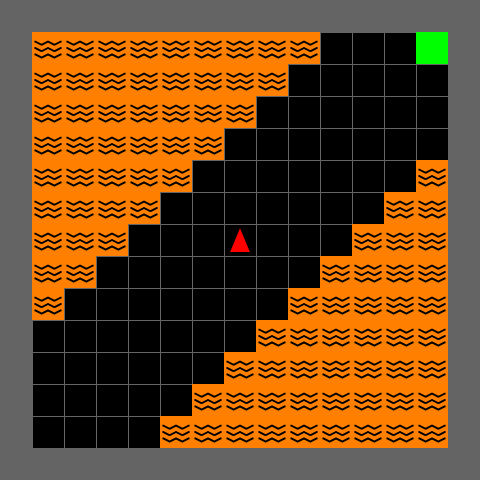



Computing new shield
LOG: Starting with explicit model creation...
Elapsed time is 0.053414344787597656 seconds.
LOG: Starting with model checking...
Elapsed time is 0.0018138885498046875 seconds.
LOG: Starting to translate shield...
Elapsed time is 0.08892679214477539 seconds.


Computing new shield
LOG: Starting with explicit model creation...
Elapsed time is 0.04616570472717285 seconds.
LOG: Starting with model checking...
Elapsed time is 0.0017552375793457031 seconds.
LOG: Starting to translate shield...
 WARN (PreShield.cpp:50): No shielding action possible with absolute comparison for state with index 1211
 WARN (PreShield.cpp:50): No shielding action possible with absolute comparison for state with index 1222
 WARN (PreShield.cpp:50): No shielding action possible with absolute comparison for state with index 1233
 WARN (PreShield.cpp:50): No shielding action possible with absolute comparison for state with index 1244
 WARN (PreShield.cpp:50): No shielding action possible with 

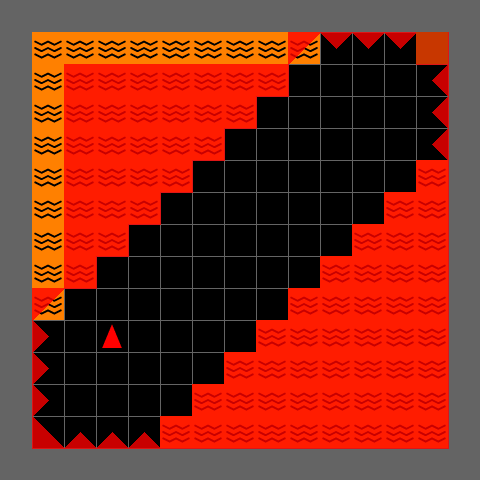

The shield for shield_value = 0.0


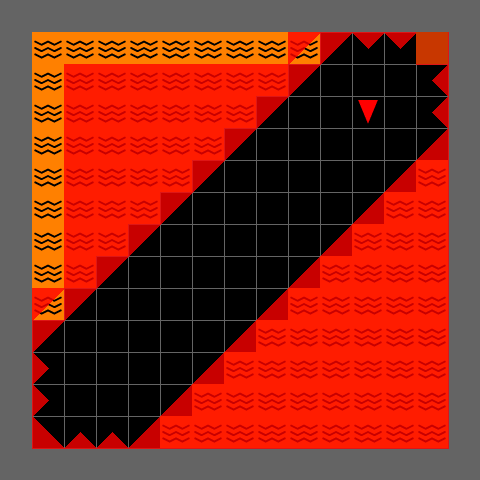

The shield for shield_value = 0.9


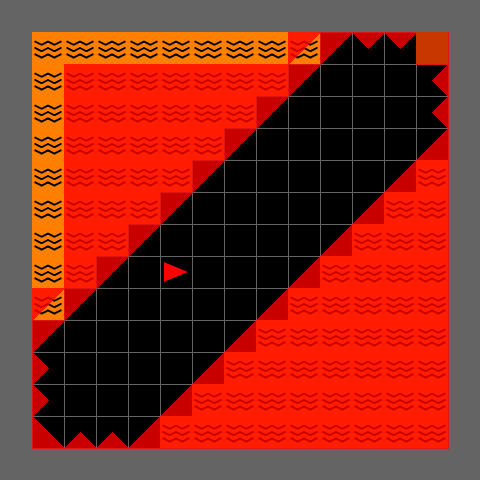

The shield for shield_value = 0.99


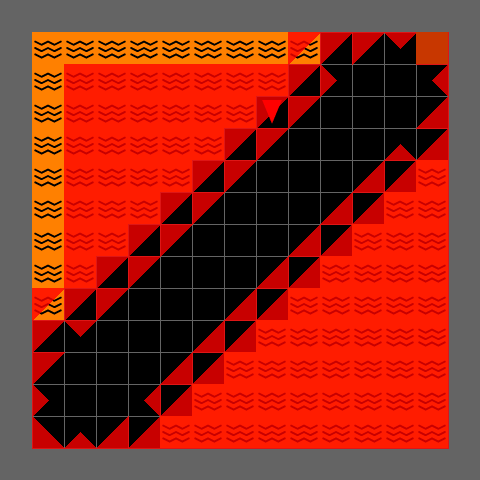

The shield for shield_value = 0.999


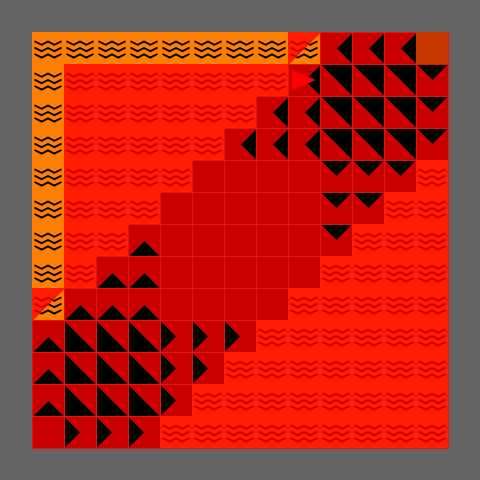

The shield for shield_value = 1.0
Training with shield:


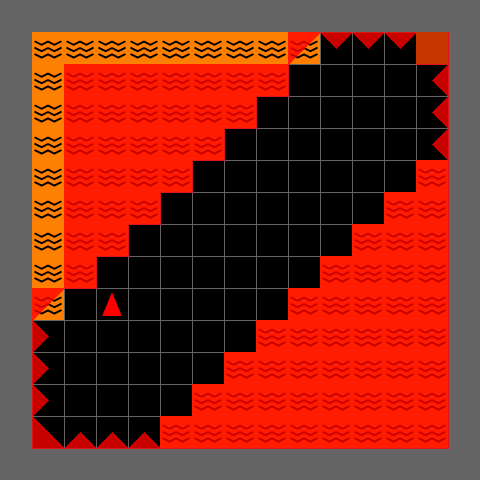

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


AssertionError: 

In [3]:
GRID_TO_PRISM_BINARY=os.getenv("M2P_BINARY")

def mask_fn(env: gym.Env):
    return env.create_action_mask()

def nomask_fn(env: gym.Env):
    return [1.0] * 7

def main():
    env = "MiniGrid-LavaFaultyS15-1-v0"
    
    formula = "Pmax=? [G ! AgentIsOnLava]"
    value_for_training = 0.0
    shield_comparison =  "absolute"
    shielding = ShieldingConfig.Training
    
    logger = Logger("/tmp", output_formats=[HumanOutputFormat(sys.stdout)])
    
    env = gym.make(env, render_mode="rgb_array")
    image_env = RGBImgObsWrapper(env, TILE_PIXELS)
    env = RGBImgObsWrapper(env, 8)
    env = ImgObsWrapper(env)
    env = MiniWrapper(env)

    
    env.reset()
    Image.fromarray(env.render()).show()

    shield_values = [0.0, 0.9, 0.99, 0.999, 1.0]
    shield_handlers = dict()
    if shield_needed(shielding):
        for value in shield_values: 
            shield_handler = MiniGridShieldHandler(GRID_TO_PRISM_BINARY, "grid.txt", "grid.prism", formula, shield_value=value, shield_comparison=shield_comparison, nocleanup=False, prism_file=None)
            env = MiniGridSbShieldingWrapper(env, shield_handler=shield_handler, create_shield_at_reset=False)
            shield_handlers[value] = shield_handler

    if shield_needed(shielding):
        for value in shield_values:            
            create_shield_overlay_image(image_env, shield_handlers[value].create_shield())
            print(f"The shield for shield_value = {value}")


    if shielding == ShieldingConfig.Training:
        env = MiniGridSbShieldingWrapper(env, shield_handler=shield_handlers[value_for_training], create_shield_at_reset=False)
        env = ActionMasker(env, mask_fn)
        print("Training with shield:")
        create_shield_overlay_image(image_env, shield_handlers[value_for_training].create_shield())
    elif shielding == ShieldingConfig.Disabled:
        env = ActionMasker(env, nomask_fn)
    else:
        assert(False) 
    model = MaskablePPO("CnnPolicy", env, verbose=1, device="auto")
    model.set_logger(logger)
    steps = 20_000

    assert(False)
    model.learn(steps,callback=[InfoCallback()])



if __name__ == '__main__':
    print("Starting the training")
    main()